# Models

In [ ]:
pip install lofo-importance

In [ ]:
pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, KFold
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as ltb
import shap

### Loading and combining cleaned Dataframes

In [3]:
df_2015 = pd.read_csv('Final_BS_2015.csv')
df_2016 = pd.read_csv('Final_BS_2016.csv')
df_2017 = pd.read_csv('Final_BS_2017.csv')
df_2018 = pd.read_csv('Final_BS_2018.csv')
df_2019 = pd.read_csv('Final_BS_2019.csv')
df_2020 = pd.read_csv('Final_BS_2020.csv')
df_2021 = pd.read_csv('Final_BS_2021.csv')
df_2022 = pd.read_csv('Final_BS_2022.csv')

In [4]:
full_regression_df = pd.concat([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,df_2021,df_2022])

### Dropping duplicates and unnecessary columns

In [5]:
full_regression_df.drop_duplicates(keep='first', inplace=True)

In [6]:
full_regression_df_drop = ['Unnamed: 0', 'team_abbr', 'opponent_name', 'opponent_abbr', 'ranking', 'win_percentage', 'assist_percentage', 'block_percentage',
 'blocks', 'defensive_rating', 'defensive_rebound_percentage', 'defensive_rebounds', 'effective_field_goal_percentage', 'field_goal_attempts', 
 'field_goal_percentage', 'field_goals', 'free_throw_attempt_rate', 'free_throw_attempts', 'free_throw_percentage', 'free_throws', 'losses', 'minutes_played',
 'offensive_rating', 'offensive_rebound_percentage', 'offensive_rebounds', 'personal_fouls', 'steal_percentage', 'steals', 'three_point_attempt_rate',
 'three_point_field_goal_attempts', 'three_point_field_goal_percentage', 'three_point_field_goals', 'total_rebound_percentage', 'total_rebounds',
 'true_shooting_percentage', 'turnover_percentage', 'turnovers', 'two_point_field_goal_attempts', 'two_point_field_goal_percentage', 'two_point_field_goals',
 'opponent_ranking', 'opponent_win_percentage', 'opponent_assist_percentage', 'opponent_assists', 'opponent_block_percentage', 'opponent_blocks',
 'opponent_defensive_rating', 'opponent_defensive_rebound_percentage', 'opponent_defensive_rebounds', 'opponent_effective_field_goal_percentage',
 'opponent_field_goal_attempts', 'opponent_field_goal_percentage', 'opponent_field_goals', 'opponent_free_throw_attempt_rate', 'opponent_free_throw_attempts',
 'opponent_free_throw_percentage', 'opponent_free_throws', 'opponent_losses', 'opponent_minutes_played', 'opponent_offensive_rating', 'opponent_offensive_rebound_percentage',
 'opponent_offensive_rebounds', 'opponent_personal_fouls', 'opponent_points', 'opponent_steal_percentage', 'opponent_steals', 'opponent_three_point_attempt_rate',
 'opponent_three_point_field_goal_attempts', 'opponent_three_point_field_goal_percentage', 'opponent_three_point_field_goals', 'opponent_total_rebound_percentage',
 'opponent_total_rebounds', 'opponent_true_shooting_percentage', 'opponent_turnover_percentage', 'opponent_turnovers', 'opponent_two_point_field_goal_attempts',
 'opponent_two_point_field_goal_percentage', 'opponent_two_point_field_goals', 'pace', 'winner', 'assists'] #'BoxscoreIndex'

In [7]:
full_regression_df_regression = full_regression_df.drop(full_regression_df_drop, axis = 1)
full_regression_df_regression.set_index('BoxscoreIndex', inplace = True)

### Drop NAN Values

In [8]:
full_regression_df_regression.dropna(axis=0, how='any', inplace = True)#, thresh=None, subset=None, inplace=False)

### Defining Target

In [9]:
y = full_regression_df_regression['points']
X = full_regression_df_regression.drop(['points','team_name'], axis = 1)

### Splitting into Training and Test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Feature Importance

### Correlation

In [12]:
correlation_df = pd.DataFrame(X.corrwith(y), columns=['Pearson Correlation Coefficient'])
correlation_df.sort_values(by=['Pearson Correlation Coefficient'], ascending=False, inplace=True)
top_20_corr = correlation_df.head(20)
top_20_corr.to_csv('top_20_corr.csv')

In [69]:
heatmaplist = list(top_20_corr.index)
heatmaplist.append('points')

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


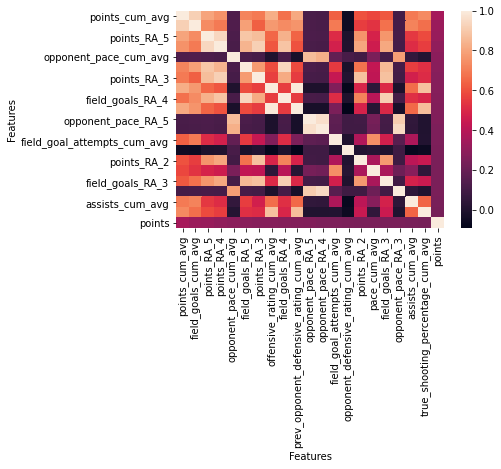

In [105]:
#sns.pairplot(top_20_corr, y_vars= ['points'], x_vars= list(top_20_corr.columns), height=10, aspect=0.6)

sns.heatmap(full_regression_df_regression[heatmaplist].corr()).set(xlabel='Features', ylabel='Features')
plt.tight_layout(pad=5)#, w_pad=2, h_pad=2)
plt.savefig('CorrHeatMap.png')

## Gain

In [26]:
gain = pd.DataFrame(sorted(zip(lgbm.booster_.feature_importance(importance_type='gain'),X.columns), reverse= True), columns=['Value','Feature'])

In [27]:
gain.to_csv('total_gain.csv')

In [28]:
top_20_gain = gain.head(20)
top_20_gain.to_csv('top_20_gain.csv')

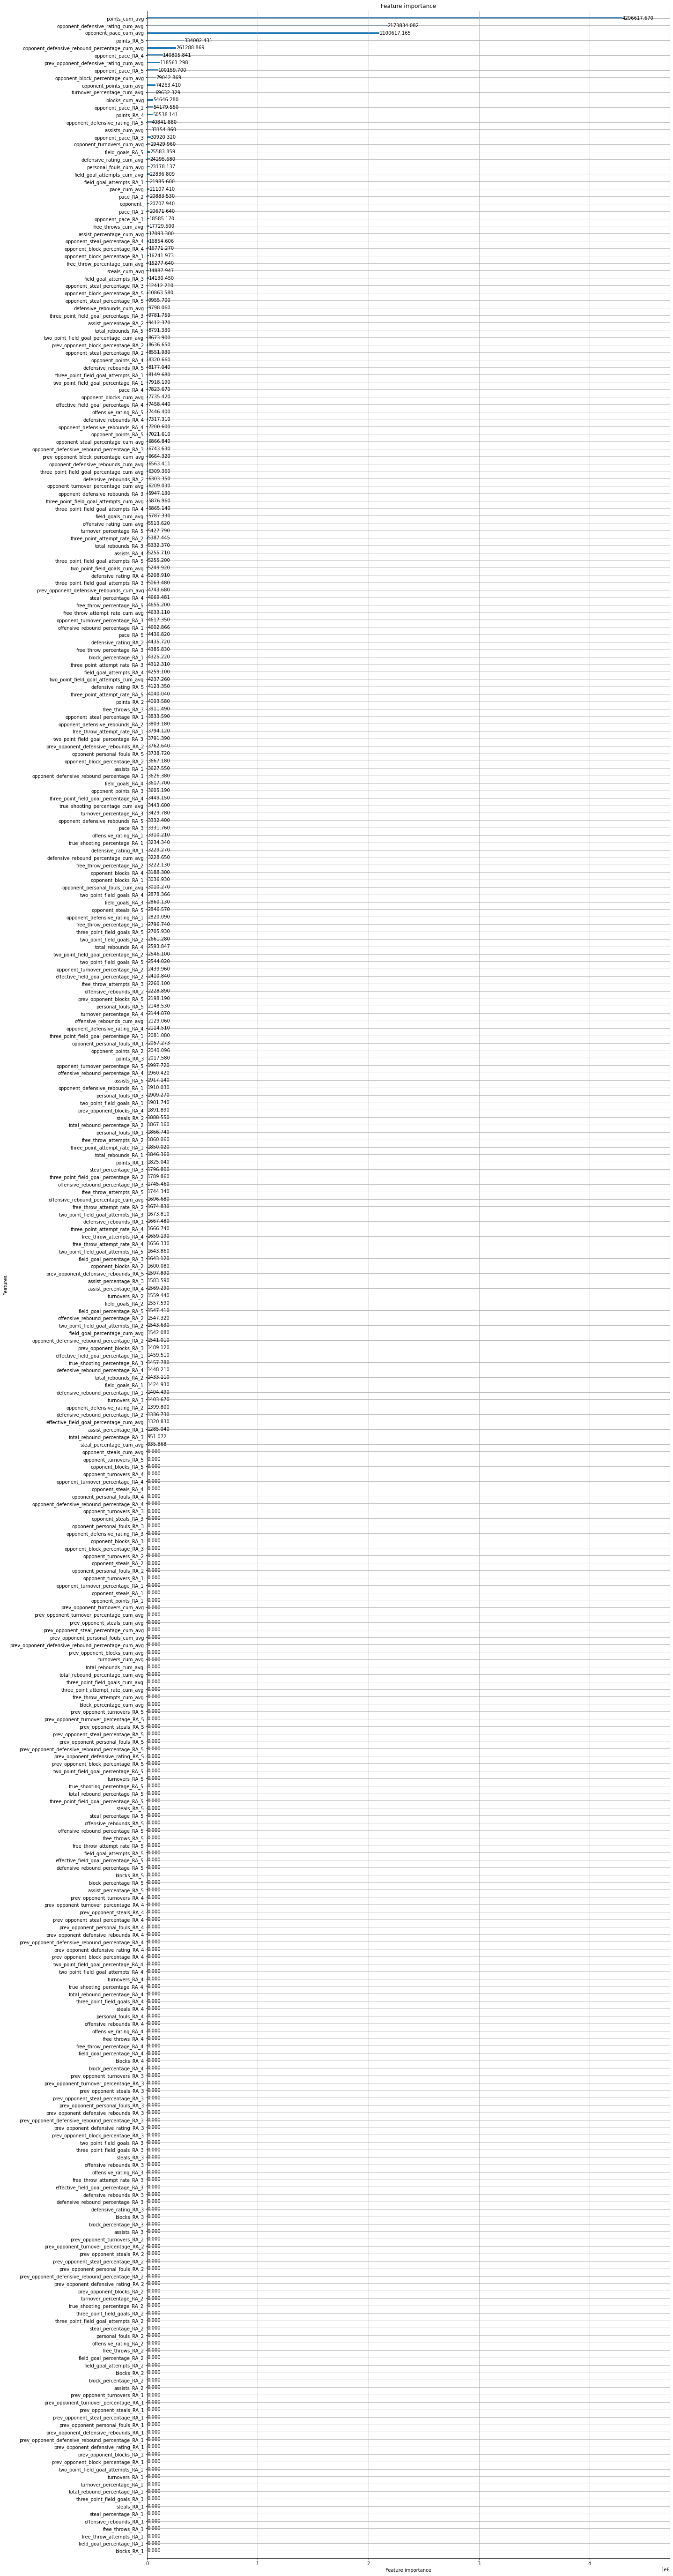

In [29]:
ltb.plot_importance(lgbm, title='Feature importance (Gain)', xlabel='Feature importance', ylabel='Features', 
                     importance_type='gain', ignore_zero = False, figsize=(20, 100))

plt.savefig('gain.png')

## Split

In [30]:
split = pd.DataFrame(sorted(zip(lgbm.booster_.feature_importance(importance_type='split'),X.columns), reverse= True), columns=['Value','Feature'])

In [31]:
split.to_csv('total_split.csv')

In [32]:
top_20_split = split.head(20)
top_20_split.to_csv('top_20_split.csv')

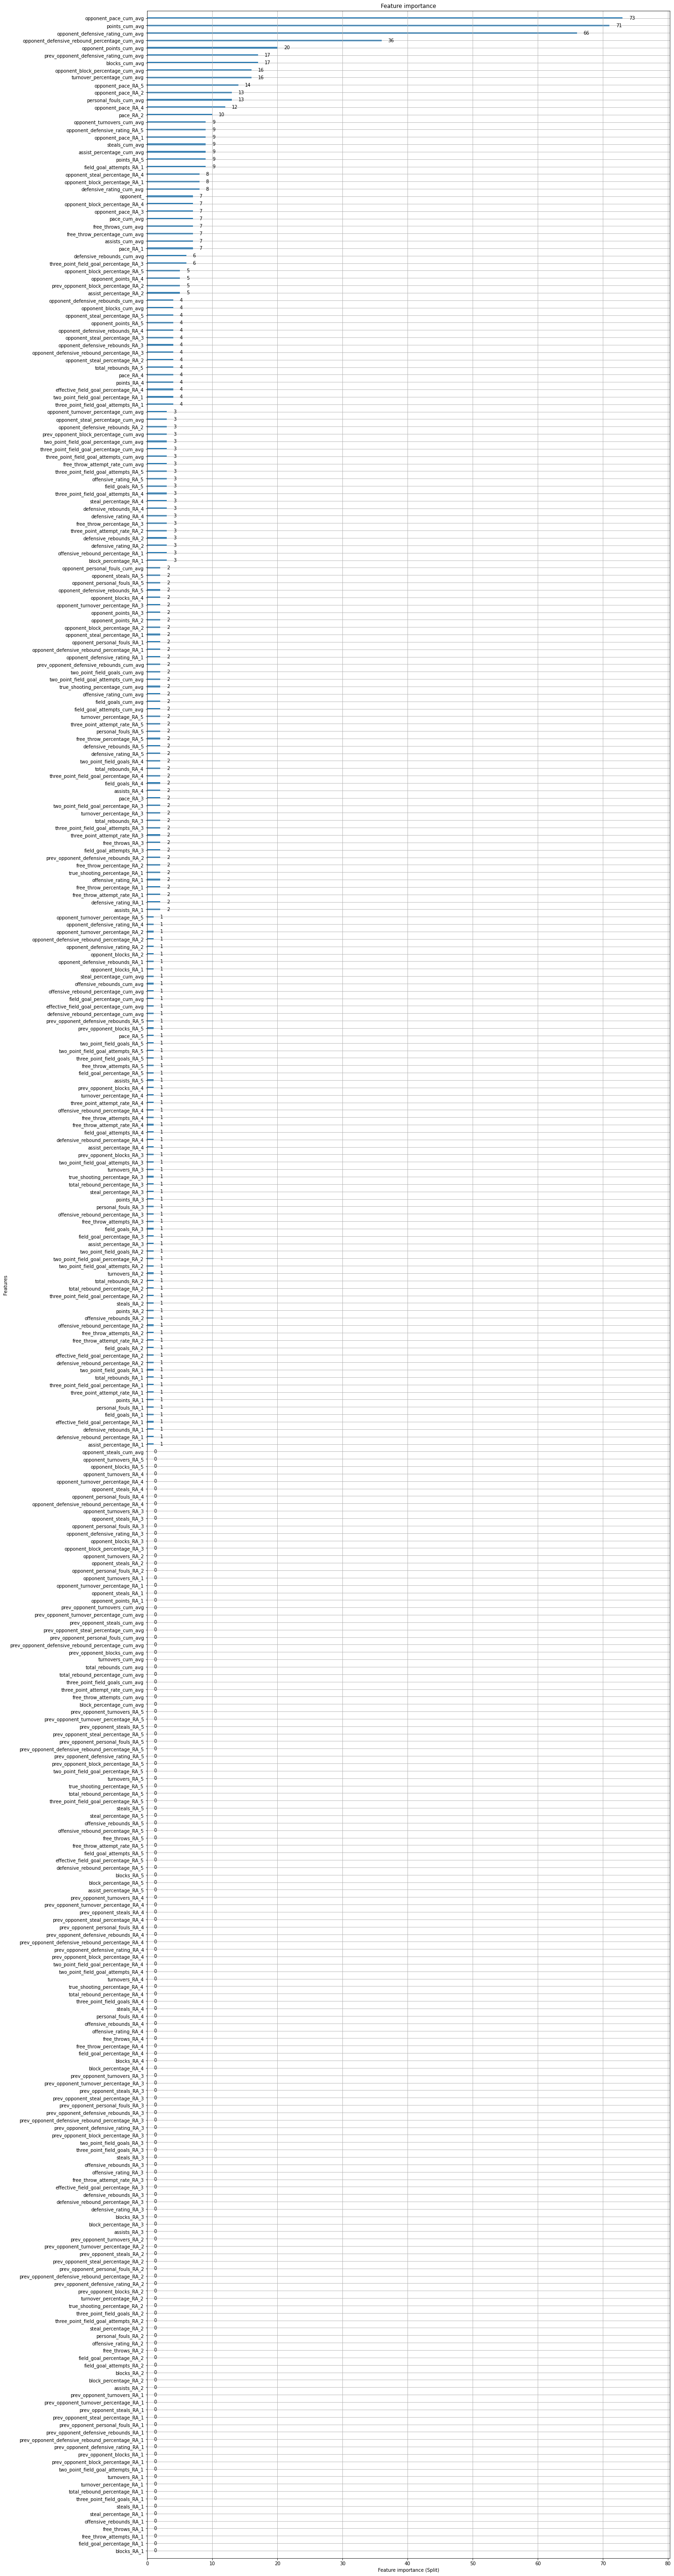

In [33]:
ltb.plot_importance(lgbm, title='Feature importance (Split)', xlabel='Feature importance (split)', ylabel='Features', 
                     importance_type='split', ignore_zero = False, figsize=(20, 100))

plt.savefig('split.png')

# LightGradientBoostingRegressor

In [20]:
lgbm = ltb.LGBMRegressor(num_leaves=7,
                        learning_rate=0.09,
                        n_estimators=1000)

In [21]:
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='l1',
         early_stopping_rounds=10)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's l1: 9.51994	valid_0's l2: 143.406
[2]	valid_0's l1: 9.40905	valid_0's l2: 140.088
[3]	valid_0's l1: 9.31196	valid_0's l2: 137.209
[4]	valid_0's l1: 9.22734	valid_0's l2: 134.727
[5]	valid_0's l1: 9.14685	valid_0's l2: 132.405
[6]	valid_0's l1: 9.07967	valid_0's l2: 130.332
[7]	valid_0's l1: 9.019	valid_0's l2: 128.612
[8]	valid_0's l1: 8.96044	valid_0's l2: 126.984
[9]	valid_0's l1: 8.91229	valid_0's l2: 125.643
[10]	valid_0's l1: 8.86792	valid_0's l2: 124.347
[11]	valid_0's l1: 8.82873	valid_0's l2: 123.302
[12]	valid_0's l1: 8.78944	valid_0's l2: 122.248
[13]	valid_0's l1: 8.7562	valid_0's l2: 121.356
[14]	valid_0's l1: 8.72625	valid_0's l2: 120.561
[15]	valid_0's l1: 8.70047	valid_0's l2: 119.825
[16]	valid_0's l1: 8.67702	valid_0's l2: 119.121
[17]	valid_0's l1: 8.65631	valid_0's l2: 118.514
[18]	valid_0's l1: 8.63437	valid_0's l2: 117.938
[19]	valid_0's l1: 8.61615	valid_0's l2: 117.435
[20]	valid_0's l1: 8.5976	valid_0's l2: 116.895
[21]	valid_0's l1: 8.58169	valid_

LGBMRegressor(learning_rate=0.09, n_estimators=1000, num_leaves=7)

In [22]:
interations = lgbm.best_iteration_

In [23]:
y_pred = lgbm.predict(X_test, num_iteration=interations)

In [24]:
mean_absolute_percentage_error(y_test, y_pred)

0.12351910112637432

### Removing Gain features

In [35]:
post_split_gain = list(split[split['Value'] > 0].Feature)

### Redefining X

In [36]:
X1 = X[post_split_gain]

In [37]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.1, random_state=42)

In [38]:
lgbm.fit(X_train1, y_train1,
         eval_set=[(X_test1, y_test1)],
         eval_metric='l1',
         early_stopping_rounds=10)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's l1: 9.51994	valid_0's l2: 143.406
[2]	valid_0's l1: 9.40905	valid_0's l2: 140.088
[3]	valid_0's l1: 9.31196	valid_0's l2: 137.209
[4]	valid_0's l1: 9.22734	valid_0's l2: 134.727
[5]	valid_0's l1: 9.14685	valid_0's l2: 132.405
[6]	valid_0's l1: 9.07967	valid_0's l2: 130.332
[7]	valid_0's l1: 9.019	valid_0's l2: 128.612
[8]	valid_0's l1: 8.96044	valid_0's l2: 126.984
[9]	valid_0's l1: 8.91229	valid_0's l2: 125.643
[10]	valid_0's l1: 8.86792	valid_0's l2: 124.347
[11]	valid_0's l1: 8.82873	valid_0's l2: 123.302
[12]	valid_0's l1: 8.78944	valid_0's l2: 122.248
[13]	valid_0's l1: 8.7562	valid_0's l2: 121.356
[14]	valid_0's l1: 8.72625	valid_0's l2: 120.561
[15]	valid_0's l1: 8.70047	valid_0's l2: 119.825
[16]	valid_0's l1: 8.67702	valid_0's l2: 119.121
[17]	valid_0's l1: 8.65631	valid_0's l2: 118.514
[18]	valid_0's l1: 8.63437	valid_0's l2: 117.938
[19]	valid_0's l1: 8.61615	valid_0's l2: 117.435
[20]	valid_0's l1: 8.5976	valid_0's l2: 116.895
[21]	valid_0's l1: 8.58169	valid_

LGBMRegressor(learning_rate=0.09, n_estimators=1000, num_leaves=7)

In [39]:
interations = lgbm.best_iteration_

In [40]:
y_pred1 = lgbm.predict(X_test1, num_iteration=interations)

In [41]:
mean_absolute_percentage_error(y_test1, y_pred1)

0.12351910112637432

### SHAP

In [42]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train1)

In [43]:
feature_names = X_train1.columns
shap_df = pd.DataFrame(shap_values, columns=feature_names)
vals = np.abs(shap_values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['Feature', 'Shap'])
shap_importance.sort_values(by=['Shap'], ascending=False, inplace=True)
shap_importance.to_csv('all_shap.csv')

In [44]:
shap_top_20 = shap_importance.head(20)
shap_top_20.to_csv('shap_top_20.csv')

In [45]:
shap_top_20

,Feature,Shap
1,points_cum_avg,2.448900
2,opponent_defensive_rating_cum_avg,1.786114
0,opponent_pace_cum_avg,1.625877
3,opponent_defensive_rebound_percentage_cum_avg,0.605451
15,points_RA_5,0.371358
5,prev_opponent_defensive_rating_cum_avg,0.258074
8,opponent_block_percentage_cum_avg,0.252032
4,opponent_points_cum_avg,0.192401
12,opponent_pace_RA_4,0.189101
7,turnover_percentage_cum_avg,0.188098


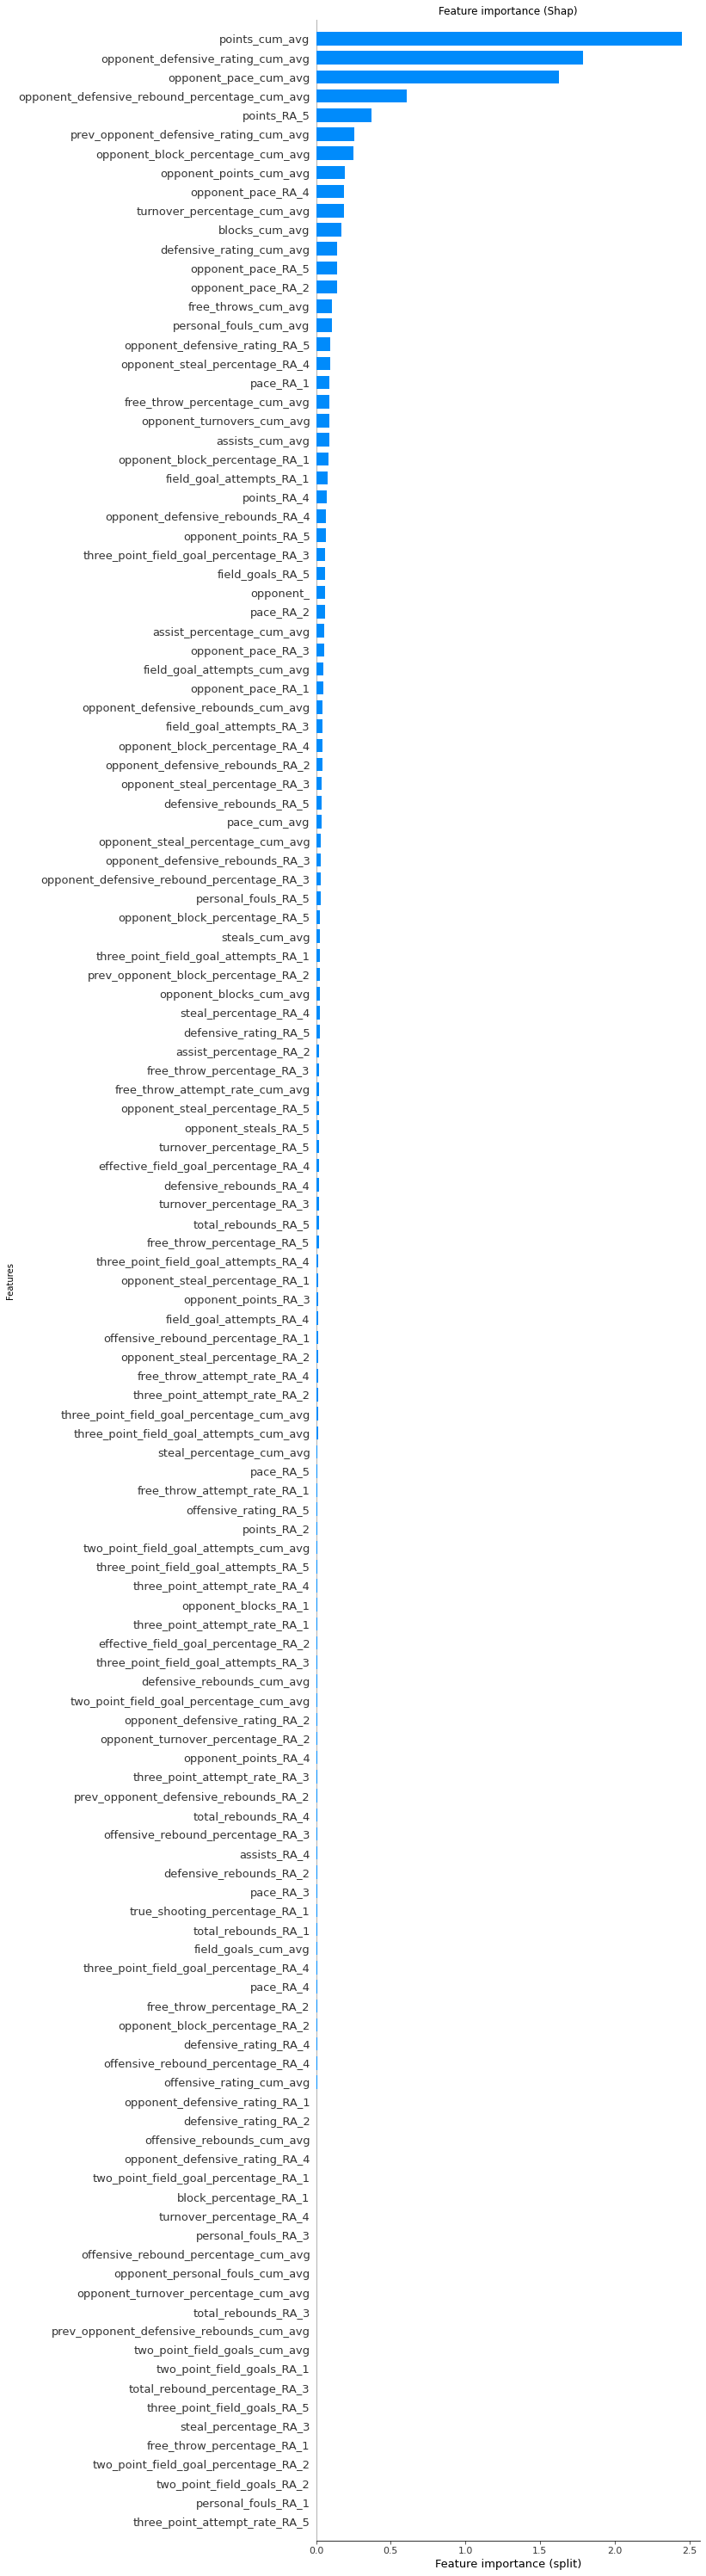

In [51]:
shap.summary_plot(shap_values, X_train1, max_display= 131, plot_type='bar', show=False)
plt.title('Feature importance (Shap)')
plt.xlabel('Feature importance (split)')
plt.ylabel('Features')
plt.show()

### Post SHAP model

In [75]:
post_shap = shap_importance[shap_importance['Shap'] >= .1].Feature

In [76]:
X2 = X1[post_shap]

In [77]:
list(X2.columns)

['points_cum_avg',
 'opponent_defensive_rating_cum_avg',
 'opponent_pace_cum_avg',
 'opponent_defensive_rebound_percentage_cum_avg',
 'points_RA_5',
 'prev_opponent_defensive_rating_cum_avg',
 'opponent_block_percentage_cum_avg',
 'opponent_points_cum_avg',
 'opponent_pace_RA_4',
 'turnover_percentage_cum_avg',
 'blocks_cum_avg',
 'defensive_rating_cum_avg',
 'opponent_pace_RA_5',
 'opponent_pace_RA_2',
 'free_throws_cum_avg',
 'personal_fouls_cum_avg']

In [78]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.1, random_state=42)

In [79]:
lgbm.fit(X_train2, y_train2,
         eval_set=[(X_test2, y_test2)],
         eval_metric='l1',
         early_stopping_rounds=10)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's l1: 9.51994	valid_0's l2: 143.406
[2]	valid_0's l1: 9.40905	valid_0's l2: 140.088
[3]	valid_0's l1: 9.31196	valid_0's l2: 137.209
[4]	valid_0's l1: 9.22734	valid_0's l2: 134.727
[5]	valid_0's l1: 9.14685	valid_0's l2: 132.405
[6]	valid_0's l1: 9.07967	valid_0's l2: 130.332
[7]	valid_0's l1: 9.019	valid_0's l2: 128.612
[8]	valid_0's l1: 8.96044	valid_0's l2: 126.984
[9]	valid_0's l1: 8.91229	valid_0's l2: 125.643
[10]	valid_0's l1: 8.86792	valid_0's l2: 124.347
[11]	valid_0's l1: 8.82873	valid_0's l2: 123.302
[12]	valid_0's l1: 8.78944	valid_0's l2: 122.248
[13]	valid_0's l1: 8.7562	valid_0's l2: 121.356
[14]	valid_0's l1: 8.72625	valid_0's l2: 120.561
[15]	valid_0's l1: 8.70126	valid_0's l2: 119.849
[16]	valid_0's l1: 8.67755	valid_0's l2: 119.155
[17]	valid_0's l1: 8.65722	valid_0's l2: 118.533
[18]	valid_0's l1: 8.63394	valid_0's l2: 117.928
[19]	valid_0's l1: 8.61475	valid_0's l2: 117.427
[20]	valid_0's l1: 8.59635	valid_0's l2: 116.889
[21]	valid_0's l1: 8.5791	valid_

LGBMRegressor(learning_rate=0.09, n_estimators=1000, num_leaves=7)

In [80]:
interations = lgbm.best_iteration_

In [81]:
y_pred2 = lgbm.predict(X_test2, num_iteration=interations)

In [82]:
mean_absolute_percentage_error(y_test2, y_pred2)

0.12350114097303358

### Correlation

In [83]:
correlation_df = pd.DataFrame(X.corrwith(y), columns=['Pearson Correlation Coefficient'])
correlation_df.reset_index(inplace=True)
correlation_df.rename({'index':'Feature'}, axis = 1, inplace = True)
post_correlation_features = correlation_df[correlation_df['Pearson Correlation Coefficient'] >= .1].Feature

In [84]:
correlation_df.to_csv('total_correlation.csv')

In [85]:
remove = list(set(X2.columns) - set(post_correlation_features))

In [88]:
X3 = X2.drop(remove, axis = 1)

In [89]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.1, random_state=42)

In [90]:
lgbm.fit(X_train3, y_train3,
         eval_set=[(X_test3, y_test3)],
         eval_metric='l1',
         early_stopping_rounds=10)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's l1: 9.51994	valid_0's l2: 143.406
[2]	valid_0's l1: 9.40905	valid_0's l2: 140.088
[3]	valid_0's l1: 9.31196	valid_0's l2: 137.209
[4]	valid_0's l1: 9.22734	valid_0's l2: 134.727
[5]	valid_0's l1: 9.14685	valid_0's l2: 132.405
[6]	valid_0's l1: 9.07967	valid_0's l2: 130.332
[7]	valid_0's l1: 9.019	valid_0's l2: 128.612
[8]	valid_0's l1: 8.96044	valid_0's l2: 126.984
[9]	valid_0's l1: 8.91229	valid_0's l2: 125.643
[10]	valid_0's l1: 8.86792	valid_0's l2: 124.347
[11]	valid_0's l1: 8.82873	valid_0's l2: 123.302
[12]	valid_0's l1: 8.78944	valid_0's l2: 122.248
[13]	valid_0's l1: 8.7562	valid_0's l2: 121.356
[14]	valid_0's l1: 8.72625	valid_0's l2: 120.561
[15]	valid_0's l1: 8.70126	valid_0's l2: 119.849
[16]	valid_0's l1: 8.67755	valid_0's l2: 119.155
[17]	valid_0's l1: 8.65722	valid_0's l2: 118.533
[18]	valid_0's l1: 8.63586	valid_0's l2: 117.964
[19]	valid_0's l1: 8.6181	valid_0's l2: 117.489
[20]	valid_0's l1: 8.59998	valid_0's l2: 116.961
[21]	valid_0's l1: 8.58529	valid_

LGBMRegressor(learning_rate=0.09, n_estimators=1000, num_leaves=7)

In [91]:
interations = lgbm.best_iteration_

In [92]:
y_pred3 = lgbm.predict(X_test3, num_iteration=interations)

In [93]:
y_pred_df = pd.DataFrame(y_pred3, columns = ['A'])

In [96]:
mean_absolute_percentage_error(y_test3, y_pred3)

0.12406478390234363

In [97]:
X3.columns

Index(['points_cum_avg', 'opponent_defensive_rating_cum_avg',
       'opponent_pace_cum_avg', 'points_RA_5',
       'prev_opponent_defensive_rating_cum_avg', 'opponent_points_cum_avg',
       'opponent_pace_RA_4', 'opponent_pace_RA_5', 'opponent_pace_RA_2',
       'free_throws_cum_avg'],
      dtype='object')

# Testing a certain game

In [ ]:
opponent_rename = {'team_name': 'opponent_name', 
                   'team_abbr': 'opponent_abbr',
                   'assist_percentage_RA_1':'opponent_assist_percentage_RA_1',
              'assists_RA_1':'opponent_assists_RA_1', 
              'block_percentage_RA_1':'opponent_block_percentage_RA_1',
              'blocks_RA_1':'opponent_blocks_RA_1', 
              'defensive_rating_RA_1':'opponent_defensive_rating_RA_1', 
              'defensive_rebound_percentage_RA_1':'opponent_defensive_rebound_percentage_RA_1', 
              'defensive_rebounds_RA_1':'opponent_defensive_rebounds_RA_1',
              'effective_field_goal_percentage_RA_1':'opponent_effective_field_goal_percentage_RA_1', 
              'field_goal_attempts_RA_1':'opponent_field_goal_attempts_RA_1', 
              'field_goal_percentage_RA_1':'opponent_field_goal_percentage_RA_1',
              'field_goals_RA_1':'opponent_field_goals_RA_1', 
              'free_throw_attempt_rate_RA_1':'opponent_free_throw_attempt_rate_RA_1', 
              'free_throw_attempts_RA_1':'opponent_free_throw_attempts_RA_1', 
              'free_throw_percentage_RA_1':'opponent_free_throw_percentage_RA_1',
              'free_throws_RA_1':'opponent_free_throws_RA_1', 
              'offensive_rating_RA_1':'opponent_offensive_rating_RA_1', 
              'offensive_rebound_percentage_RA_1':'opponent_offensive_rebound_percentage_RA_1', 
              'offensive_rebounds_RA_1':'opponent_offensive_rebounds_RA_1',
              'personal_fouls_RA_1':'opponent_personal_fouls_RA_1', 
              'points_RA_1':'opponent_points_RA_1', 
              'steal_percentage_RA_1':'opponent_steal_percentage_RA_1', 
              'steals_RA_1':'opponent_steals_RA_1', 
              'three_point_attempt_rate_RA_1':'opponent_three_point_attempt_rate_RA_1',
              'three_point_field_goal_attempts_RA_1':'opponent_three_point_field_goal_attempts_RA_1', 
              'three_point_field_goal_percentage_RA_1':'opponent_three_point_field_goal_percentage_RA_1', 
              'three_point_field_goals_RA_1':'opponent_three_point_field_goals_RA_1',
              'total_rebound_percentage_RA_1':'opponent_total_rebound_percentage_RA_1', 
              'total_rebounds_RA_1':'opponent_total_rebounds_RA_1', 
              'true_shooting_percentage_RA_1':'opponent_true_shooting_percentage_RA_1', 
              'turnover_percentage_RA_1':'opponent_turnover_percentage_RA_1',
              'turnovers_RA_1':'opponent_turnovers_RA_1', 
              'two_point_field_goal_attempts_RA_1':'opponent_two_point_field_goal_attempts_RA_1', 
              'two_point_field_goal_percentage_RA_1':'opponent_two_point_field_goal_percentage_RA_1', 
              'two_point_field_goals_RA_1':'opponent_two_point_field_goals_RA_1',
              'pace_RA_1':'opponent_pace_RA_1', 
              'assist_percentage_RA_2':'opponent_assist_percentage_RA_2', 
              'assists_RA_2':'opponent_assists_RA_2', 
              'block_percentage_RA_2':'opponent_block_percentage_RA_2', 
              'blocks_RA_2':'opponent_blocks_RA_2', 
              'defensive_rating_RA_2':'opponent_defensive_rating_RA_2',
              'defensive_rebound_percentage_RA_2':'opponent_defensive_rebound_percentage_RA_2', 
              'defensive_rebounds_RA_2':'opponent_defensive_rebounds_RA_2', 
              'effective_field_goal_percentage_RA_2':'opponent_effective_field_goal_percentage_RA_2', 
              'field_goal_attempts_RA_2':'opponent_field_goal_attempts_RA_2',
              'field_goal_percentage_RA_2':'opponent_field_goal_percentage_RA_2', 
              'field_goals_RA_2':'opponent_field_goals_RA_2', 
              'free_throw_attempt_rate_RA_2':'opponent_free_throw_attempt_rate_RA_2', 
              'free_throw_attempts_RA_2':'opponent_free_throw_attempts_RA_2',
              'free_throw_percentage_RA_2':'opponent_free_throw_percentage_RA_2', 
              'free_throws_RA_2':'opponent_free_throws_RA_2', 
              'offensive_rating_RA_2':'opponent_offensive_rating_RA_2', 
              'offensive_rebound_percentage_RA_2':'opponent_offensive_rebound_percentage_RA_2',
              'offensive_rebounds_RA_2':'opponent_offensive_rebounds_RA_2', 
              'personal_fouls_RA_2':'opponent_personal_fouls_RA_2', 
              'points_RA_2':'opponent_points_RA_2', 
              'steal_percentage_RA_2':'opponent_steal_percentage_RA_2', 
              'steals_RA_2':'opponent_steals_RA_2',
              'three_point_attempt_rate_RA_2':'opponent_three_point_attempt_rate_RA_2', 
              'three_point_field_goal_attempts_RA_2':'opponent_three_point_field_goal_attempts_RA_2', 
              'three_point_field_goal_percentage_RA_2':'opponent_three_point_field_goal_percentage_RA_2',
              'three_point_field_goals_RA_2':'opponent_three_point_field_goals_RA_2', 
              'total_rebound_percentage_RA_2':'opponent_total_rebound_percentage_RA_2', 
              'total_rebounds_RA_2':'opponent_total_rebounds_RA_2', 
              'true_shooting_percentage_RA_2':'opponent_true_shooting_percentage_RA_2',
              'turnover_percentage_RA_2':'opponent_turnover_percentage_RA_2', 
              'turnovers_RA_2':'opponent_turnovers_RA_2', 
              'two_point_field_goal_attempts_RA_2':'opponent_two_point_field_goal_attempts_RA_2', 
              'two_point_field_goal_percentage_RA_2':'opponent_two_point_field_goal_percentage_RA_2',
              'two_point_field_goals_RA_2':'opponent_two_point_field_goals_RA_2', 
              'pace_RA_2':'opponent_pace_RA_2', 
              'assist_percentage_RA_3':'opponent_assist_percentage_RA_3', 
              'assists_RA_3':'opponent_assists_RA_3', 
              'block_percentage_RA_3':'opponent_block_percentage_RA_3',
              'blocks_RA_3':'opponent_blocks_RA_3', 
              'defensive_rating_RA_3':'opponent_defensive_rating_RA_3', 
              'defensive_rebound_percentage_RA_3':'opponent_defensive_rebound_percentage_RA_3', 
              'defensive_rebounds_RA_3':'opponent_defensive_rebounds_RA_3',
              'effective_field_goal_percentage_RA_3':'opponent_effective_field_goal_percentage_RA_3', 
              'field_goal_attempts_RA_3':'opponent_field_goal_attempts_RA_3', 
              'field_goal_percentage_RA_3':'opponent_field_goal_percentage_RA_3',
              'field_goals_RA_3':'opponent_field_goals_RA_3', 
              'free_throw_attempt_rate_RA_3':'opponent_free_throw_attempt_rate_RA_3', 
              'free_throw_attempts_RA_3':'opponent_free_throw_attempts_RA_3', 
              'free_throw_percentage_RA_3':'opponent_free_throw_percentage_RA_3',
              'free_throws_RA_3':'opponent_free_throws_RA_3', 
              'offensive_rating_RA_3':'opponent_offensive_rating_RA_3', 
              'offensive_rebound_percentage_RA_3':'opponent_offensive_rebound_percentage_RA_3', 
              'offensive_rebounds_RA_3':'opponent_offensive_rebounds_RA_3',
              'personal_fouls_RA_3':'opponent_personal_fouls_RA_3', 
              'points_RA_3':'opponent_points_RA_3', 
              'steal_percentage_RA_3':'opponent_steal_percentage_RA_3', 
              'steals_RA_3':'opponent_steals_RA_3', 
              'three_point_attempt_rate_RA_3':'opponent_three_point_attempt_rate_RA_3',
              'three_point_field_goal_attempts_RA_3':'opponent_three_point_field_goal_attempts_RA_3', 
              'three_point_field_goal_percentage_RA_3':'opponent_three_point_field_goal_percentage_RA_3', 
              'three_point_field_goals_RA_3':'opponent_three_point_field_goals_RA_3',
              'total_rebound_percentage_RA_3':'opponent_total_rebound_percentage_RA_3',
              'total_rebounds_RA_3':'opponent_total_rebounds_RA_3', 
              'true_shooting_percentage_RA_3':'opponent_true_shooting_percentage_RA_3', 
              'turnover_percentage_RA_3':'opponent_turnover_percentage_RA_3',
              'turnovers_RA_3':'opponent_turnovers_RA_3', 
              'two_point_field_goal_attempts_RA_3':'opponent_two_point_field_goal_attempts_RA_3', 
              'two_point_field_goal_percentage_RA_3':'opponent_two_point_field_goal_percentage_RA_3', 
              'two_point_field_goals_RA_3':'opponent_two_point_field_goals_RA_3',
              'pace_RA_3':'opponent_pace_RA_3', 
              'assist_percentage_RA_4':'opponent_assist_percentage_RA_4', 
              'assists_RA_4':'opponent_assists_RA_4', 
              'block_percentage_RA_4':'opponent_block_percentage_RA_4', 
              'blocks_RA_4':'opponent_blocks_RA_4', 
              'defensive_rating_RA_4':'opponent_defensive_rating_RA_4',
              'defensive_rebound_percentage_RA_4':'opponent_defensive_rebound_percentage_RA_4', 
              'defensive_rebounds_RA_4':'opponent_defensive_rebounds_RA_4', 
              'effective_field_goal_percentage_RA_4':'opponent_effective_field_goal_percentage_RA_4', 
              'field_goal_attempts_RA_4':'opponent_field_goal_attempts_RA_4',
              'field_goal_percentage_RA_4':'opponent_field_goal_percentage_RA_4', 
              'field_goals_RA_4':'opponent_field_goals_RA_4', 
              'free_throw_attempt_rate_RA_4':'opponent_free_throw_attempt_rate_RA_4', 
              'free_throw_attempts_RA_4':'opponent_free_throw_attempts_RA_4',
              'free_throw_percentage_RA_4':'opponent_free_throw_percentage_RA_4', 
              'free_throws_RA_4':'opponent_free_throws_RA_4', 
              'offensive_rating_RA_4':'opponent_offensive_rating_RA_4', 
              'offensive_rebound_percentage_RA_4':'opponent_offensive_rebound_percentage_RA_4',
              'offensive_rebounds_RA_4':'opponent_offensive_rebounds_RA_4', 
              'personal_fouls_RA_4':'opponent_personal_fouls_RA_4', 
              'points_RA_4':'opponent_points_RA_4', 
              'steal_percentage_RA_4':'opponent_steal_percentage_RA_4', 
              'steals_RA_4':'opponent_steals_RA_4', 
              'three_point_attempt_rate_RA_4':'opponent_three_point_attempt_rate_RA_4', 
              'three_point_field_goal_attempts_RA_4':'opponent_three_point_field_goal_attempts_RA_4', 
              'three_point_field_goal_percentage_RA_4':'opponent_three_point_field_goal_percentage_RA_4',
              'three_point_field_goals_RA_4':'opponent_three_point_field_goals_RA_4', 
              'total_rebound_percentage_RA_4':'opponent_total_rebound_percentage_RA_4', 
              'total_rebounds_RA_4':'opponent_total_rebounds_RA_4', 
              'true_shooting_percentage_RA_4':'opponent_true_shooting_percentage_RA_4',
              'turnover_percentage_RA_4':'opponent_turnover_percentage_RA_4', 
              'turnovers_RA_4':'opponent_turnovers_RA_4', 
              'two_point_field_goal_attempts_RA_4':'opponent_two_point_field_goal_attempts_RA_4', 
              'two_point_field_goal_percentage_RA_4':'opponent_two_point_field_goal_percentage_RA_4',
              'two_point_field_goals_RA_4':'opponent_two_point_field_goals_RA_4', 
              'pace_RA_4':'opponent_pace_RA_4', 
              'assist_percentage_RA_5':'opponent_assist_percentage_RA_5', 
              'assists_RA_5':'opponent_assists_RA_5', 
              'block_percentage_RA_5':'opponent_block_percentage_RA_5',
              'blocks_RA_5':'opponent_blocks_RA_5', 
              'defensive_rating_RA_5':'opponent_defensive_rating_RA_5', 
              'defensive_rebound_percentage_RA_5':'opponent_defensive_rebound_percentage_RA_5', 
              'defensive_rebounds_RA_5':'opponent_defensive_rebounds_RA_5', 
              'effective_field_goal_percentage_RA_5':'opponent_effective_field_goal_percentage_RA_5',
              'field_goal_attempts_RA_5':'opponent_field_goal_attempts_RA_5', 
              'field_goal_percentage_RA_5':'opponent_field_goal_percentage_RA_5', 
              'field_goals_RA_5':'opponent_field_goals_RA_5', 
              'free_throw_attempt_rate_RA_5':'opponent_free_throw_attempt_rate_RA_5',
              'free_throw_attempts_RA_5':'opponent_free_throw_attempts_RA_5', 
              'free_throw_percentage_RA_5':'opponent_free_throw_percentage_RA_5', 
              'free_throws_RA_5':'opponent_free_throws_RA_5', 
              'offensive_rating_RA_5':'opponent_offensive_rating_RA_5',
              'offensive_rebound_percentage_RA_5':'opponent_offensive_rebound_percentage_RA_5', 
              'offensive_rebounds_RA_5':'opponent_offensive_rebounds_RA_5', 
              'personal_fouls_RA_5':'opponent_personal_fouls_RA_5', 
              'points_RA_5':'opponent_points_RA_5',
              'steal_percentage_RA_5':'opponent_steal_percentage_RA_5', 
              'steals_RA_5':'opponent_steals_RA_5', 
              'three_point_attempt_rate_RA_5':'opponent_three_point_attempt_rate_RA_5', 
              'three_point_field_goal_attempts_RA_5':'opponent_three_point_field_goal_attempts_RA_5',
              'three_point_field_goal_percentage_RA_5':'opponent_three_point_field_goal_percentage_RA_5', 
              'three_point_field_goals_RA_5':'opponent_three_point_field_goals_RA_5', 
              'total_rebound_percentage_RA_5':'opponent_total_rebound_percentage_RA_5',
              'total_rebounds_RA_5':'opponent_total_rebounds_RA_5', 
              'true_shooting_percentage_RA_5':'opponent_true_shooting_percentage_RA_5', 
              'turnover_percentage_RA_5':'opponent_turnover_percentage_RA_5', 
              'turnovers_RA_5':'opponent_turnovers_RA_5', 
              'two_point_field_goal_attempts_RA_5':'opponent_two_point_field_goal_attempts_RA_5', 
              'two_point_field_goal_percentage_RA_5':'opponent_two_point_field_goal_percentage_RA_5', 
              'two_point_field_goals_RA_5':'opponent_two_point_field_goals_RA_5',
              'pace_RA_5':'opponent_pace_RA_5', 
              'assists_cum_avg':'opponent_assists_cum_avg', 
              'assist_percentage_cum_avg':'opponent_assist_percentage_cum_avg', 
              'block_percentage_cum_avg':'opponent_block_percentage_cum_avg', 
              'blocks_cum_avg':'opponent_blocks_cum_avg',
              'defensive_rating_cum_avg':'opponent_defensive_rating_cum_avg', 
              'defensive_rebound_percentage_cum_avg':'opponent_defensive_rebound_percentage_cum_avg', 
              'defensive_rebounds_cum_avg':'opponent_defensive_rebounds_cum_avg',
              'effective_field_goal_percentage_cum_avg':'opponent_effective_field_goal_percentage_cum_avg', 
              'field_goal_attempts_cum_avg':'opponent_field_goal_attempts_cum_avg', 
              'field_goal_percentage_cum_avg':'opponent_field_goal_percentage_cum_avg',
              'field_goals_cum_avg':'opponent_field_goals_cum_avg', 
              'free_throw_attempt_rate_cum_avg':'opponent_free_throw_attempt_rate_cum_avg', 
              'free_throw_attempts_cum_avg':'opponent_free_throw_attempts_cum_avg', 
              'free_throw_percentage_cum_avg':'opponent_free_throw_percentage_cum_avg',
              'free_throws_cum_avg':'opponent_free_throws_cum_avg', 
              'offensive_rating_cum_avg':'opponent_offensive_rating_cum_avg', 
              'offensive_rebound_percentage_cum_avg':'opponent_offensive_rebound_percentage_cum_avg', 
              'offensive_rebounds_cum_avg':'opponent_offensive_rebounds_cum_avg',
              'personal_fouls_cum_avg':'opponent_personal_fouls_cum_avg', 
              'points_cum_avg':'opponent_points_cum_avg', 
              'steal_percentage_cum_avg':'opponent_steal_percentage_cum_avg', 
              'steals_cum_avg':'opponent_steals_cum_avg', 
              'three_point_attempt_rate_cum_avg':'opponent_three_point_attempt_rate_cum_avg',
              'three_point_field_goal_attempts_cum_avg':'opponent_three_point_field_goal_attempts_cum_avg', 
              'three_point_field_goal_percentage_cum_avg':'opponent_three_point_field_goal_percentage_cum_avg', 
              'three_point_field_goals_cum_avg':'opponent_three_point_field_goals_cum_avg',
              'total_rebound_percentage_cum_avg':'opponent_total_rebound_percentage_cum_avg', 
              'total_rebounds_cum_avg':'opponent_total_rebounds_cum_avg', 
              'true_shooting_percentage_cum_avg':'opponent_true_shooting_percentage_cum_avg', 
              'turnover_percentage_cum_avg':'opponent_turnover_percentage_cum_avg',
              'turnovers_cum_avg':'opponent_turnovers_cum_avg', 
              'two_point_field_goal_attempts_cum_avg':'opponent_two_point_field_goal_attempts_cum_avg', 
              'two_point_field_goal_percentage_cum_avg':'opponent_two_point_field_goal_percentage_cum_avg', 
              'two_point_field_goals_cum_avg':'opponent_two_point_field_goals_cum_avg',
              'pace_cum_avg':'opponent_pace_cum_avg'}

In [ ]:
df_2022 = pd.read_csv('Final_BS_2022_holdout.csv')
df_2022.set_index('BoxscoreIndex', inplace = True)
df_2022.head(1)

In [ ]:
#list(df_2022.columns)

In [ ]:
previous_BoxscoreIndex = '2022-04-02-18-kansas'
team_1 = df_2022.loc[[previous_BoxscoreIndex]]
team_1

In [ ]:
team_1_name = "Kansas"
team_1 = team_1.drop(full_regression_df_drop, axis = 1)
team_1 = team_1[team_1['team_name'] == team_1_name]
team_1_no_prev = team_1[team_1.columns.drop(list(team_1.filter(regex='opponent')))]
drop_opponent_list_1 = [word for word in list(team_1.columns) if word.startswith('opponent')]
team_1.drop(drop_opponent_list_1, axis=1, inplace = True)

In [ ]:
#drop_opponent_list_1 = [word for word in list(team_1.columns) if word.startswith('opponent')]

In [ ]:
#df_2022.loc['2022-03-07-19-georgia-state']

In [ ]:
previous_BoxscoreIndex = '2022-04-02-20-duke'
team_2 = df_2022.loc[[previous_BoxscoreIndex]]
team_2

In [ ]:
team_2_name = "UNC"
team_2 = team_2.drop(full_regression_df_drop, axis = 1)
team_2 = team_2[team_2['team_name'] == team_2_name]
team_2_no_prev = team_2[team_2.columns.drop(list(team_2.filter(regex='opponent')))]
drop_opponent_list_2 = [word for word in list(team_2.columns) if word.startswith('opponent')]
team_2.drop(drop_opponent_list_2, axis=1, inplace = True)

In [ ]:
team_1.reset_index(inplace= True)
team_2.reset_index(inplace= True)

In [ ]:
team_2_opponent = team_2_no_prev.rename(columns = opponent_rename)
team_1_opponent = team_1_no_prev.rename(columns = opponent_rename)

In [ ]:
team_2_opponent.reset_index(inplace= True)
team_1_opponent.reset_index(inplace= True)

In [ ]:
particular_game_team_1 = pd.concat([team_1,team_2_opponent], axis = 1)

In [ ]:
particular_game_team_2 = pd.concat([team_2,team_1_opponent], axis = 1)

In [ ]:
particular_game_team_1

In [ ]:
team_1_name = particular_game_team_1['team_name']
team_2_name = particular_game_team_2['team_name']

In [ ]:
particular_game_team_1.reset_index(inplace = True)
particular_game_team_2.reset_index(inplace = True)

In [ ]:
particular_game_team_1.drop(['points','BoxscoreIndex','team_name','index', 'opponent_name'], axis = 1, inplace = True)
particular_game_team_2.drop(['points','BoxscoreIndex','team_name','index', 'opponent_name'], axis = 1, inplace = True)

In [ ]:
particular_game_columns = list(X3.columns)

In [ ]:
particular_game_team_1 = particular_game_team_1[particular_game_columns]
particular_game_team_2 = particular_game_team_2[particular_game_columns]

In [ ]:
particular_game_team_1

In [ ]:
#list(X3.columns)

In [ ]:
team_1_pred = lgbm.predict(particular_game_team_1, num_iteration=interations)
team_2_pred = lgbm.predict(particular_game_team_2, num_iteration=interations)

In [ ]:
pd.DataFrame([team_1_name, team_1_pred, team_2_name, team_2_pred])

In [ ]:
team_1_name

In [ ]:
team_1_pred

In [ ]:
team_2_name

In [ ]:
team_2_pred

In [ ]:
particular_game_team_1.columns

In [ ]:
game_example = lgbm.predict(X_tourney, num_iteration=interations)

In [ ]:
game_example

In [ ]:
X_tourney.drop(['team_name', 'opponent_name'], axis = 1, inplace = True)

In [ ]:
list(X_tourney.columns)

In [ ]:

team_1.set_index('team_name', inplace = True)
team_1.drop(['index', 'level_0'], axis = 1, inplace= True)

In [ ]:
team_1_x = team_1.drop(['points','BoxscoreIndex'], axis = 1)

In [ ]:
team_1_x

In [ ]:
team_2_x = team_2.drop(['points','BoxscoreIndex','team_name'], axis = 1)

In [ ]:
model = ltb.LGBMRegressor() #Use grid search for better params

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
#ltb.importance(lgbm, percentage = TRUE)

In [ ]:

#SKLEARN MODEL CAN NOT RANK FEATURES


# evaluate the model
model = HistGradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingRegressor()
model.fit(X, y)

# Removing NAN Values

In [ ]:
full_regression_df_no_na = full_regression_df.dropna()

In [ ]:
y = full_regression_df_no_na['points']
X = full_regression_df_no_na.drop('points', axis = 1)

# GradientBoostingRegressor 
Need to remove NAN

In [ ]:
model = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# Linear Regression

In [ ]:
linreg = LinearRegression()

In [ ]:
model_1 = linreg.fit(X, y)

In [ ]:
coeff_df = pd.DataFrame(list(model_1.coef_), list(X.columns), columns=['coefficient'])
coeff_df['coefficient'].sort_values(ascending = False)
plt.figure(figsize=(12,10))
coeff_df.coefficient.plot(kind='barh',figsize=(12,10))